# Análise Visual da Notação Big O com Algoritmos de Ordenação

**Objetivo:** Este notebook demonstra de forma prática e visual a diferença de desempenho entre algoritmos de ordenação, conectando os resultados com a notação **Big O** correspondente.

Todos os algoritmos são plotados **no mesmo gráfico** para uma comparação direta e impactante de suas taxas de crescimento.

Vamos comparar três algoritmos clássicos:
*   **Bubble Sort:** `O(n²)`
*   **Insertion Sort:** `O(n²)` no caso médio, `O(n)` no melhor caso.
*   **Merge Sort:** `O(n log n)` em todos os casos.

In [20]:
# Célula de configuração: importando as bibliotecas necessárias
import random
import time
import statistics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets

# Configurações para os gráficos ficarem mais bonitos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## Bloco 1: As Ferramentas do Nosso Experimento

Definimos aqui nossas "ferramentas":
1.  **Geradores de Dados:** Para simular os cenários de caso médio, melhor caso e pior caso.
2.  **Algoritmos de Ordenação:** As implementações do Bubble, Insertion e Merge Sort.
3.  **Funções de Medição e Plotagem:** O código que irá executar os algoritmos, medir o tempo e gerar **dois gráficos** para análise:
    *   Um **gráfico geral** mostrando a imagem completa do crescimento.
    *   Um **gráfico com zoom** para inspecionar o comportamento para `n` pequeno, onde as constantes importam.

In [21]:
# 1. GERADORES DE DADOS e 2. ALGORITMOS

def gerar_lista_aleatoria(n):
    return [random.randint(0, n * 10) for _ in range(n)]
def gerar_lista_ordenada(n):
    return list(range(n))
def gerar_lista_reversa(n):
    return list(range(n - 1, -1, -1))

def bubble_sort(a):
    a = a.copy(); n = len(a)
    for i in range(n - 1):
        for j in range(n - i - 1):
            if a[j] > a[j + 1]: a[j], a[j + 1] = a[j + 1], a[j]
    return a

def insertion_sort(a):
    a = a.copy()
    for i in range(1, len(a)):
        key, j = a[i], i - 1
        while j >= 0 and a[j] > key: a[j + 1], j = a[j], j - 1
        a[j + 1] = key
    return a

def merge_sort(a):
    if len(a) <= 1: return a
    m = len(a) // 2
    return merge(merge_sort(a[:m]), merge_sort(a[m:]))

def merge(l, r):
    res, i, j = [], 0, 0
    while i < len(l) and j < len(r):
        if l[i] <= r[j]: res.append(l[i]); i += 1
        else: res.append(r[j]); j += 1
    res.extend(l[i:]); res.extend(r[j:])
    return res

# 3. FUNÇÕES DE MEDIÇÃO E PLOTAGEM

def medir_e_comparar(algos, cenario_func, tamanhos, reps):
    resultados = {nome: [] for nome in algos}
    for n in tamanhos:
        tempos_por_algo = {nome: [] for nome in algos}
        for _ in range(reps):
            lista_base = cenario_func(n)
            for nome, func in algos.items():
                start = time.perf_counter(); func(lista_base); end = time.perf_counter()
                tempos_por_algo[nome].append(end - start)
        for nome in algos:
            resultados[nome].append(statistics.mean(tempos_por_algo[nome]))
    df = pd.DataFrame(resultados, index=tamanhos); df.index.name = "Tamanho (n)"
    return df

def plotar_resultados(df_resultados, titulo_cenario, complexidades_override=None):
    """
    *** FUNÇÃO DE PLOTAGEM COM GRÁFICO DUPLO (GERAL E ZOOM) ***
    Cria um gráfico combinado e, se aplicável, um segundo gráfico com zoom.
    """
    # --- Configurações Comuns ---
    n_array = np.array(df_resultados.index, dtype=float)
    complexidades_base = {
        "Bubble Sort": (lambda n: n**2, "O(n²)"), "Insertion Sort": (lambda n: n**2, "O(n²)"),
        "Merge Sort": (lambda n: n * np.log2(n), "O(n log n)"),
    }
    complexidades = complexidades_base.copy()
    if complexidades_override: complexidades.update(complexidades_override)
    cores = plt.cm.tab10(np.linspace(0, 1, len(df_resultados.columns)))

    # --- GRÁFICO 1: VISÃO GERAL ---
    fig_geral, ax_geral = plt.subplots(figsize=(12, 7))
    fig_geral.suptitle(f"Análise de Desempenho — Cenário: {titulo_cenario}", fontsize=16)

    for i, nome_algo in enumerate(df_resultados.columns):
        tempos_array = df_resultados[nome_algo].values
        cor = cores[i]
        # Linha empírica
        ax_geral.plot(n_array, tempos_array, marker='o', linestyle='-', label=f"{nome_algo} (Empírico)", color=cor)
        # Linha teórica
        if nome_algo in complexidades:
            f_comp, label_comp = complexidades[nome_algo]
            if n_array[-1] > 1 and f_comp(n_array[-1]) > 1e-9:
                vals_teoricos = f_comp(n_array)
                fator = tempos_array[-1] / vals_teoricos[-1]
                ax_geral.plot(n_array, vals_teoricos * fator, linestyle='--', label=f"Teórica {label_comp}", color=cor, alpha=0.8)

    ax_geral.set_title("Visão Geral: Comparação de Taxas de Crescimento")
    ax_geral.set_xlabel("Tamanho da Entrada (n)"); ax_geral.set_ylabel("Tempo Médio (s)")
    ax_geral.legend(); ax_geral.grid(True, linestyle=':')
    ax_geral.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.show()

    # --- GRÁFICO 2: VISÃO COM ZOOM (CONDICIONAL) ---
    # Só faz sentido criar este gráfico se estivermos comparando um algo rápido (Merge) com um lento (Bubble/Insertion)
    is_merge_present = 'Merge Sort' in df_resultados.columns
    is_quadratic_present = 'Bubble Sort' in df_resultados.columns or 'Insertion Sort' in df_resultados.columns

    if is_merge_present and is_quadratic_present:
        fig_zoom, ax_zoom = plt.subplots(figsize=(12, 7))
        for i, nome_algo in enumerate(df_resultados.columns):
            ax_zoom.plot(n_array, df_resultados[nome_algo].values, marker='o', linestyle='-', label=f"{nome_algo}", color=cores[i])

        # Define o limite do eixo Y com base no algoritmo mais rápido (Merge Sort)
        max_y_merge = df_resultados['Merge Sort'].max()
        ax_zoom.set_ylim(0, max_y_merge * 1.2)

        ax_zoom.set_title("Visão Detalhada (Zoom): Desempenho para `n` pequeno")
        ax_zoom.set_xlabel("Tamanho da Entrada (n)"); ax_zoom.set_ylabel("Tempo Médio (s)")
        ax_zoom.legend(); ax_zoom.grid(True, linestyle=':')
        plt.tight_layout(); plt.show()


# Dicionários globais
ALGORITMOS = { "Bubble Sort": bubble_sort, "Insertion Sort": insertion_sort, "Merge Sort": merge_sort, }
CENARIOS = { "Aleatório (Caso Médio)": gerar_lista_aleatoria, "Ordenado (Melhor Caso)": gerar_lista_ordenada, "Invertido (Pior Caso)": gerar_lista_reversa, }

## Bloco 2: Demonstrações Guiadas

Agora vamos rodar os experimentos. A nova visualização combinada tornará as diferenças ainda mais claras.

### Demonstração 1: O(n²) em Ação - O Custo do Crescimento Quadrático

Vamos comparar os dois algoritmos **O(n²)** no caso médio.

*   **Algoritmos:** Bubble Sort, Insertion Sort
*   **Cenário:** Aleatório (Caso Médio)
*   **Tamanhos `n`:** `[500, 1000, 2000, 4000]`

**O que observar:**
*   Na tabela, note que dobrar `n` quadruplica o tempo, aproximadamente.
*   No gráfico combinado, as duas curvas empíricas (sólidas) terão um formato parabólico muito similar, alinhando-se com suas respectivas curvas teóricas (tracejadas). O Insertion Sort deve ser consistentemente mais rápido que o Bubble Sort.

Executando Demonstração 1: Algoritmos O(n²) no Aleatório (Caso Médio)...

Resultados (tempo em segundos):


,Bubble Sort,Insertion Sort
Tamanho (n),,
500,0.012171,0.005454
1000,0.048316,0.022319
2000,0.206023,0.090490
4000,0.865069,0.383995


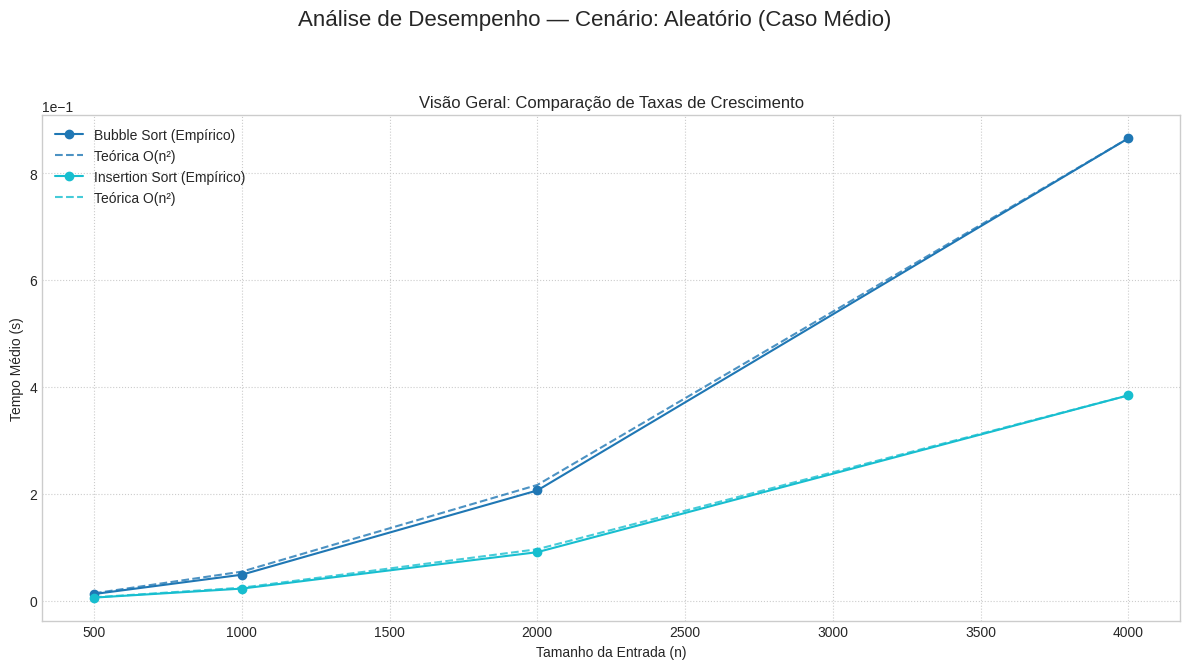

In [22]:
# Parâmetros da Demo 1
algos_demo1 = {"Bubble Sort": ALGORITMOS["Bubble Sort"], "Insertion Sort": ALGORITMOS["Insertion Sort"]}
cenario_nome1, cenario_func1 = "Aleatório (Caso Médio)", CENARIOS["Aleatório (Caso Médio)"]
tamanhos1 = [500, 1000, 2000, 4000]
reps1 = 5

print(f"Executando Demonstração 1: Algoritmos O(n²) no {cenario_nome1}...")
resultados_df1 = medir_e_comparar(algos_demo1, cenario_func1, tamanhos1, reps1)

print("\nResultados (tempo em segundos):")
display(resultados_df1.style.format("{:.6f}"))

plotar_resultados(resultados_df1, cenario_nome1)

### Demonstração 2: Revelando o "Ponto de Cruzamento"

A demonstração anterior mostrou a enorme diferença de escala entre `O(n²)` e `O(n log n)`. Agora, vamos aprofundar a análise para responder a uma pergunta crucial: **A complexidade menor do Merge Sort significa que ele é *sempre* mais rápido?**

A resposta é **não**, e a razão está nas constantes e termos de baixa ordem que a Notação Big O ignora.
*   **Insertion Sort:** Tem poucos passos por iteração. É simples e direto.
*   **Merge Sort:** Tem um `overhead` (custo) maior devido às chamadas de função recursivas e à criação de novas listas na etapa de `merge`.

Vamos provar isso usando um conjunto de `n` mais denso na faixa de valores pequenos a médios.

*   **Algoritmos:** Todos (Bubble Sort, Insertion Sort, Merge Sort)
*   **Cenário:** Aleatório (Caso Médio)
*   **Tamanhos `n`:** `[10, 20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 300, 400, 500]`
*   **Repetições:** Aumentadas para `20` para obter médias mais estáveis em tempos de execução muito curtos.

**O que observar:**

1.  **No Gráfico 1 (Visão Geral):** Continuaremos a ver o Merge Sort dominando em `n` maiores. O Bubble e Insertion Sort inevitavelmente decolam.
2.  **No Gráfico 2 (Visão com Zoom):** **Esta é a visualização chave!**
    *   Você verá claramente que para `n` muito pequeno (ex: 10, 20), a linha do **Insertion Sort está ABAIXO** da linha do Merge Sort. Ele é mais rápido!
    *   Haverá um **ponto de cruzamento** (geralmente entre n=40 e n=100) onde a linha do Merge Sort cruza a do Insertion Sort.
    *   A partir deste ponto, o crescimento mais lento `O(n log n)` do Merge Sort compensa seu `overhead` inicial, tornando-o a escolha superior para todas as entradas maiores.

Executando Demonstração 2 (Aprimorada): Revelando o ponto de cruzamento no Aleatório (Caso Médio)...

Resultados (tempo em segundos):


,Bubble Sort,Insertion Sort,Merge Sort
Tamanho (n),,,
10,0.00000574,0.00000319,0.00001161
20,0.00001756,0.00000807,0.00002068
30,0.00005060,0.00001809,0.00003398
40,0.00006593,0.00003270,0.00008600
50,0.00010347,0.00004631,0.00006135
60,0.00014052,0.00007279,0.00007356
80,0.00030577,0.00012052,0.00011172
100,0.00044677,0.00020352,0.00014734
120,0.00053069,0.00027531,0.00015669


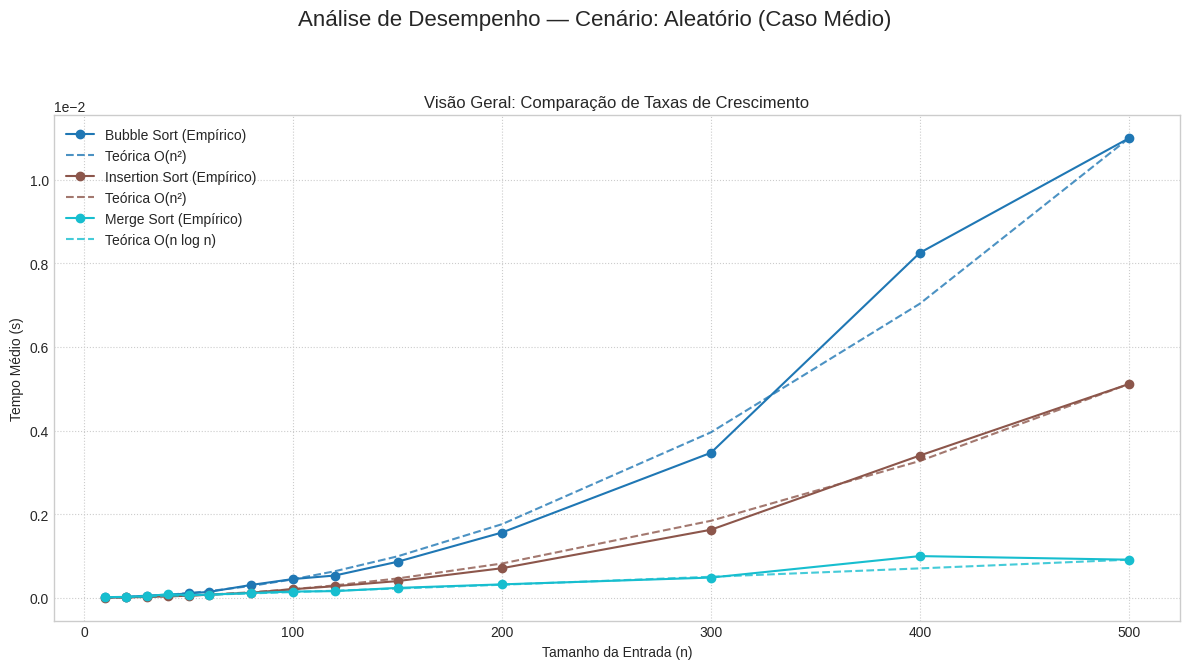

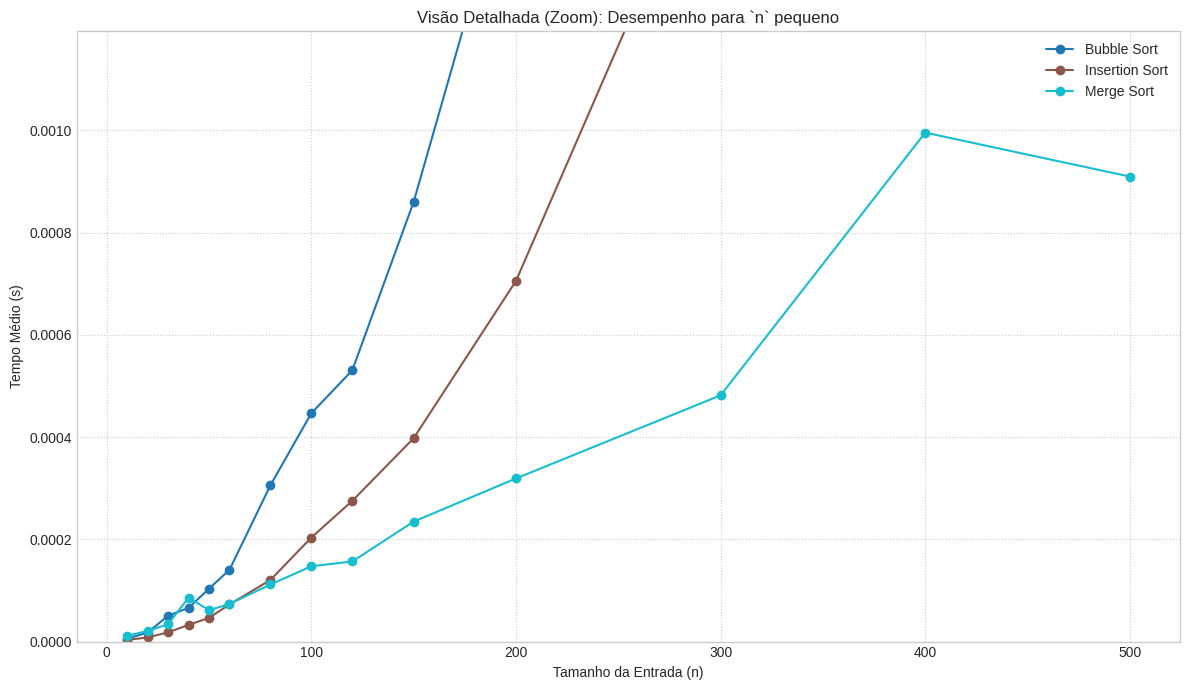

In [40]:
# Parâmetros otimizados para a Demo 2
algos_demo2 = ALGORITMOS
cenario_nome2, cenario_func2 = "Aleatório (Caso Médio)", CENARIOS["Aleatório (Caso Médio)"]

# Valores de 'n' densos no início para capturar o ponto de cruzamento
tamanhos2 = [10, 20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 300, 400, 500]

# Mais repetições para estabilizar as médias dos tempos muito curtos
reps2 = 20

print(f"Executando Demonstração 2 (Aprimorada): Revelando o ponto de cruzamento no {cenario_nome2}...")
resultados_df2 = medir_e_comparar(algos_demo2, cenario_func2, tamanhos2, reps2)

print("\nResultados (tempo em segundos):")
display(resultados_df2.style.format("{:.8f}")) # Mais casas decimais para os tempos pequenos

plotar_resultados(resultados_df2, cenario_nome2)

### Demonstração 3: O Contexto Importa - Melhor e Pior Caso

#### Parte A: O Melhor Caso do Insertion Sort (O(n))

Testaremos o Insertion Sort e o Merge Sort em uma lista **já ordenada**.

*   **Algoritmos:** Insertion Sort, Merge Sort
*   **Cenário:** Ordenado (Melhor Caso)
*   **Tamanhos `n`:** `[5000, 10000, 20000, 40000]`

**O que observar:**
*   O Insertion Sort (com sua complexidade de melhor caso **O(n)**) será ainda mais rápido que o Merge Sort! O gráfico mostrará sua curva empírica como uma linha quase reta, muito abaixo da curva `O(n log n)` do Merge Sort. Isso mostra que, para certos dados (quase ordenados), um algoritmo "mais simples" pode ser superior.

Executando Demonstração 3A: Melhor Caso do Insertion Sort vs Merge Sort...

Resultados (tempo em segundos):


,Insertion Sort,Merge Sort
Tamanho (n),,
5000,0.000577,0.008168
10000,0.001167,0.016452
20000,0.002347,0.034358
40000,0.005226,0.072773


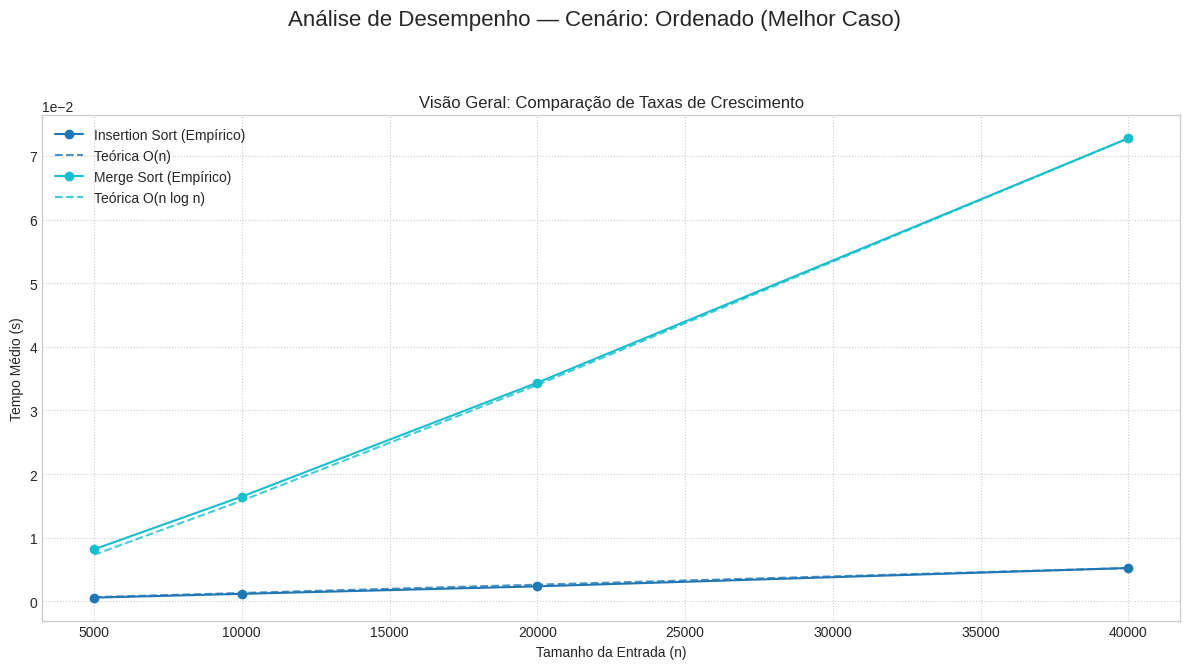

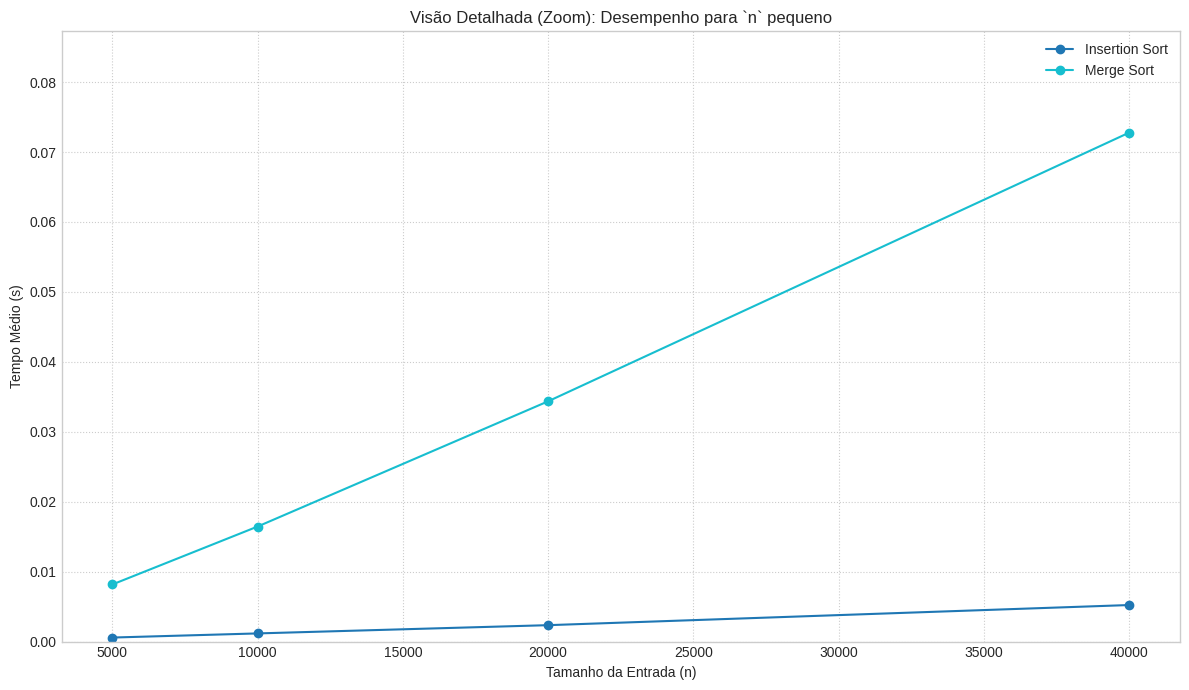

In [41]:
# Parâmetros da Demo 3A
algos_demo3a = {"Insertion Sort": ALGORITMOS["Insertion Sort"], "Merge Sort": ALGORITMOS["Merge Sort"]}
cenario_nome3a, cenario_func3a = "Ordenado (Melhor Caso)", CENARIOS["Ordenado (Melhor Caso)"]
tamanhos3a = [5000, 10000, 20000, 40000]
reps3a = 10

# Sobrescrevemos a complexidade do Insertion Sort apenas para este gráfico
override_3a = {"Insertion Sort": (lambda n: n, "O(n)")}

print(f"Executando Demonstração 3A: Melhor Caso do Insertion Sort vs Merge Sort...")
resultados_df3a = medir_e_comparar(algos_demo3a, cenario_func3a, tamanhos3a, reps3a)

print("\nResultados (tempo em segundos):")
display(resultados_df3a.style.format("{:.6f}"))

plotar_resultados(resultados_df3a, cenario_nome3a, complexidades_override=override_3a)

#### Parte B: O Pior Caso (e a Resiliência do Merge Sort)

Finalmente, o pior cenário: uma lista em ordem **reversa**.

*   **Algoritmos:** Insertion Sort, Merge Sort
*   **Cenário:** Invertido (Pior Caso)
*   **Tamanhos `n`:** `[500, 1000, 2000, 4000]`

**O que observar:**
*   A curva do Insertion Sort agora se alinha perfeitamente à sua teoria de pior caso `O(n²)`.
*   A curva do Merge Sort permanece baixa e controlada, quase idêntica ao seu desempenho no caso médio. O gráfico combinado mostra de forma clara sua estabilidade e resiliência em qualquer cenário.

Executando Demonstração 3B: Pior Caso vs Merge Sort...

Resultados (tempo em segundos):


,Insertion Sort,Merge Sort
Tamanho (n),,
500,0.009916,0.000709
1000,0.047254,0.001516
2000,0.169019,0.002792
4000,0.934732,0.007750


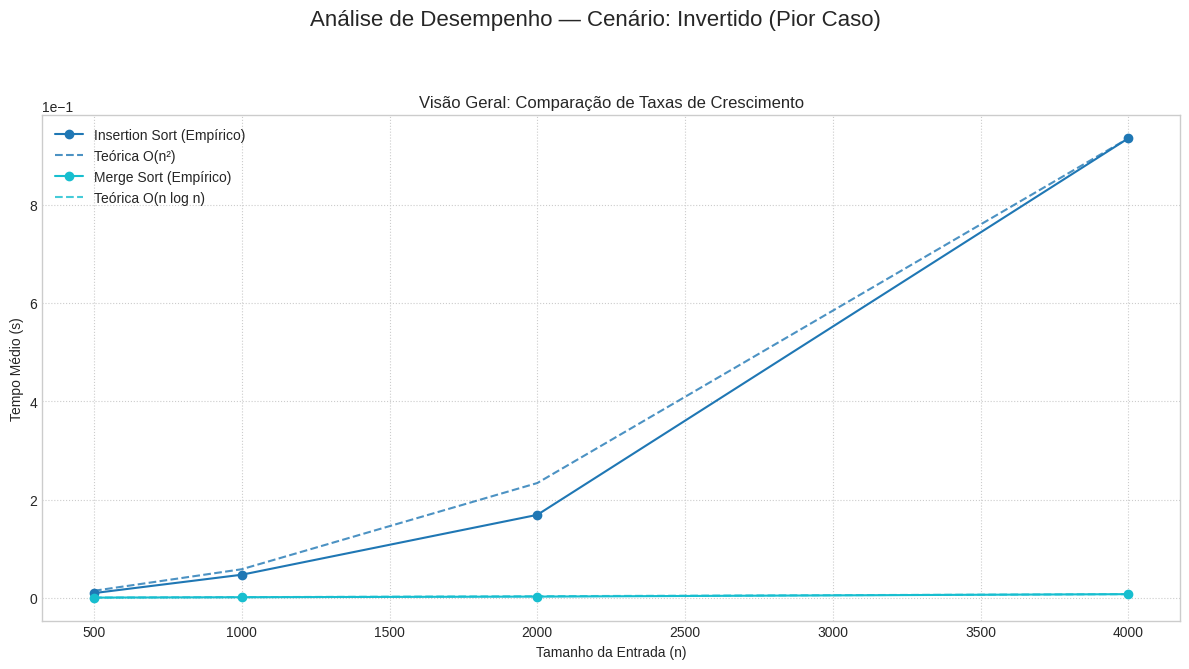

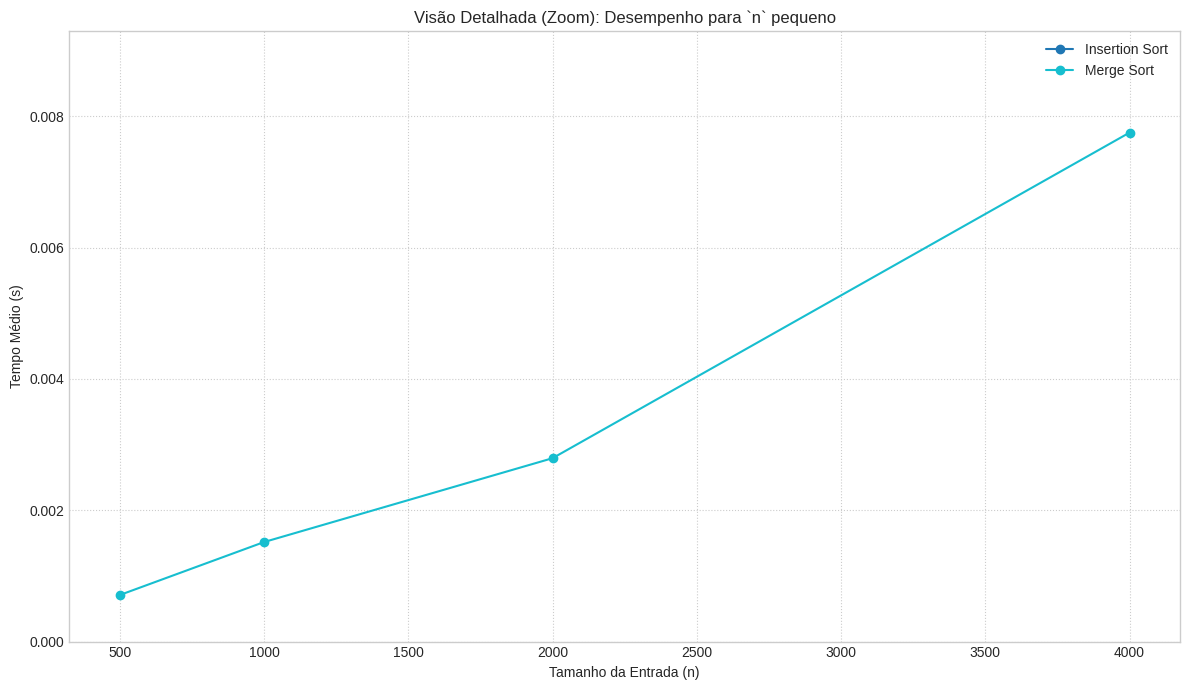

In [42]:
# Parâmetros da Demo 3B
algos_demo3b = {"Insertion Sort": ALGORITMOS["Insertion Sort"], "Merge Sort": ALGORITMOS["Merge Sort"]}
cenario_nome3b, cenario_func3b = "Invertido (Pior Caso)", CENARIOS["Invertido (Pior Caso)"]
tamanhos3b = [500, 1000, 2000, 4000]
reps3b = 5

print(f"Executando Demonstração 3B: Pior Caso vs Merge Sort...")
resultados_df3b = medir_e_comparar(algos_demo3b, cenario_func3b, tamanhos3b, reps3b)

print("\nResultados (tempo em segundos):")
display(resultados_df3b.style.format("{:.6f}"))

plotar_resultados(resultados_df3b, cenario_nome3b)

## Bloco 3: Faça Você Mesmo! (Sandbox Interativo)

Agora é a sua vez! Use os controles abaixo para configurar e rodar seu próprio experimento.

**Como usar:**
*   **Algoritmos:** Selecione um, dois ou os três algoritmos. Para selecionar múltiplos, segure a tecla `Ctrl` (ou `Cmd` em Mac) e clique nos nomes.
*   **Cenário:** Escolha o tipo de dados de entrada.
*   **Tamanhos:** Digite uma lista de números separados por vírgula. Comece com valores pequenos e aumente.
*   **Repetições:** Aumente para obter médias de tempo mais estáveis, especialmente para testes com `n` pequeno.

Clique em **"Rodar Experimento"** para ver os resultados e gráficos.

In [60]:
# A linha de importação agora inclui TODAS as classes de widget necessárias.
from ipywidgets import Label, Checkbox, HBox, VBox, Text, IntSlider, Button, Output
import traceback

# 1. CRIAÇÃO DOS WIDGETS

# -- Controles para Algoritmos --
default_algos = ['Insertion Sort', 'Merge Sort']
algo_checkboxes = {
    name: Checkbox(description=name, value=(name in default_algos), indent=False)
    for name in ALGORITMOS.keys()
}
ui_algos = HBox([Label('Algoritmos:')] + list(algo_checkboxes.values()))


# -- Controles para Cenários --
default_cenarios = ['Aleatório (Caso Médio)']
cenario_checkboxes = {
    name: Checkbox(description=name, value=(name in default_cenarios), indent=False)
    for name in CENARIOS.keys()
}
ui_cenarios = HBox([Label('Cenários:')] + list(cenario_checkboxes.values()))


# -- Outros Widgets --
wg_tamanhos = Text(
    value='10, 30, 50, 80, 120, 200, 400',
    description='Tamanhos (n):',
    style={'description_width': 'initial'}
)
wg_reps = IntSlider(
    value=5, min=1, max=50, step=1,
    description='Repetições:',
    style={'description_width': 'initial'}
)
wg_button = Button(
    description='Rodar Todos os Experimentos Selecionados',
    button_style='success',
    tooltip='Clique para iniciar a medição e gerar os gráficos',
    icon='play',
    layout={'width': 'auto'}
)
wg_output = Output()


# 2. FUNÇÃO DE CALLBACK (Sem alterações)

def on_button_clicked(b):
    with wg_output:
        clear_output(wait=True)
        try:
            algos_selecionados_nomes = [
                name for name, chk in algo_checkboxes.items() if chk.value
            ]
            cenarios_selecionados_nomes = [
                name for name, chk in cenario_checkboxes.items() if chk.value
            ]

            if not algos_selecionados_nomes:
                print("ERRO: Por favor, selecione ao menos um algoritmo.")
                return
            if not cenarios_selecionados_nomes:
                print("ERRO: Por favor, selecione ao menos um cenário.")
                return

            tamanhos_sel = sorted(list(set([int(x.strip()) for x in wg_tamanhos.value.split(',')])))
            reps_sel = wg_reps.value
            algos_para_teste = {nome: ALGORITMOS[nome] for nome in algos_selecionados_nomes}

            print("--- INICIANDO BATERIA DE TESTES ---")

            for nome_cenario in cenarios_selecionados_nomes:
                print(f"\n=========================================================")
                print(f"  EXECUTANDO CENÁRIO: {nome_cenario.upper()}")
                print(f"=========================================================\n")

                func_cenario = CENARIOS[nome_cenario]

                resultados_df = medir_e_comparar(
                    algos_para_teste,
                    func_cenario,
                    tamanhos_sel,
                    reps_sel
                )

                print("Resultados da Medição (tempo em segundos):")
                display(resultados_df.style.format("{:.8f}"))
                plotar_resultados(resultados_df, nome_cenario)

        except Exception as e:
            print("\n❌ Ocorreu um erro durante a execução.")
            print(f"   Mensagem: {e}")
            print("\n   Detalhes Técnicos:")
            traceback.print_exc()
            print("\n   Por favor, verifique os parâmetros, especialmente a lista de 'Tamanhos (n)'. Ela deve ser uma lista de números separados por vírgula (ex: 10, 50, 100).")


wg_button.on_click(on_button_clicked)

# 3. MONTAGEM DA INTERFACE FINAL (Sem alterações)

controles = VBox([
    ui_algos,
    ui_cenarios,
    HBox([wg_tamanhos, wg_reps]),
    wg_button
])

display(VBox([controles, wg_output]))

## Bloco Final: Um Interlúdio Cômico — O Infame Bogo Sort

Depois de estudar algoritmos elegantes e eficientes como o Merge Sort, é hora de conhecer o seu oposto: o **Bogo Sort**, também conhecido como "Stupid Sort" ou "Permutation Sort".

**Qual é a sua estratégia?**
1.  Verificar se a lista está ordenada.
2.  Se não estiver, embaralhe a lista aleatoriamente.
3.  Volte para o passo 1.

Ele é a encarnação algorítmica do **Teorema do Macaco Infinito**: se um macaco digitar aleatoriamente em uma máquina de escrever por um tempo infinito, eventualmente ele escreverá as obras completas de Shakespeare. Da mesma forma, o Bogo Sort, eventualmente, irá tropeçar na permutação correta da lista. A palavra-chave aqui é "eventualmente".

### A "Complexidade" da Pura Sorte

Vamos analisar por que este algoritmo é uma catástrofe computacional.
*   Para uma lista de tamanho `n`, existem **`n!` (n fatorial)** permutações possíveis.
*   A chance de encontrar a permutação correta em uma única tentativa é de `1 / n!`.
*   Em média, são necessárias `n!` tentativas (embaralhamentos) para encontrar a solução.
*   Cada tentativa envolve embaralhar a lista (operação de `O(n)`) e verificar se está ordenada (outra operação de `O(n)`).

Portanto, a complexidade de tempo média do Bogo Sort é **`O(n * n!)`**. Seu pior caso é, teoricamente, **infinito** (você pode ter um azar infinito e nunca encontrar a ordem certa).

Para colocar `n!` em perspectiva:

| n  | n! (Permutações)            | Escala                   |
|----|-----------------------------|--------------------------|
| 8  | 40.320                      | Gerenciável              |
| 9  | 362.880                     | Lento                    |
| 10 | 3.628.800                   | Muito lento              |
| 11 | 39.916.800                  | Inviável na prática      |
| 12 | 479.001.600                 | Extremamente inviável    |
| 13 | 6.227.020.800 (6+ Bilhões!) | Idade do Universo Agradece|

O código a seguir irá demonstrar duas coisas:
1.  A **extrema variação** no tempo de execução para um `n` fixo (dependência da sorte).
2.  O **crescimento explosivo** do tempo médio à medida que `n` aumenta, mesmo em uma faixa minúscula de `n=2` a `n=8`.

--- Iniciando a demonstração do Bogo Sort ---
Isso pode levar alguns minutos, especialmente para os tamanhos maiores (n=8)...

Coletando 20 medições para n=8...
  Tentativa 1/20: 0.1738 segundos
  Tentativa 2/20: 0.2081 segundos
  Tentativa 3/20: 0.0097 segundos
  Tentativa 4/20: 0.0016 segundos
  Tentativa 5/20: 0.0689 segundos
  Tentativa 6/20: 0.1870 segundos
  Tentativa 7/20: 0.0089 segundos
  Tentativa 8/20: 0.0477 segundos
  Tentativa 9/20: 0.0810 segundos
  Tentativa 10/20: 0.0436 segundos
  Tentativa 11/20: 0.4171 segundos
  Tentativa 12/20: 0.0253 segundos
  Tentativa 13/20: 0.0598 segundos
  Tentativa 14/20: 0.0243 segundos
  Tentativa 15/20: 0.0145 segundos
  Tentativa 16/20: 0.0527 segundos
  Tentativa 17/20: 0.3583 segundos
  Tentativa 18/20: 0.0526 segundos
  Tentativa 19/20: 0.1619 segundos
  Tentativa 20/20: 0.4600 segundos

Coletando médias para vários tamanhos de n...
  Média para n=2: 0.0000 segundos
  Média para n=3: 0.0000 segundos
  Média para n=4: 0.0000 segundos

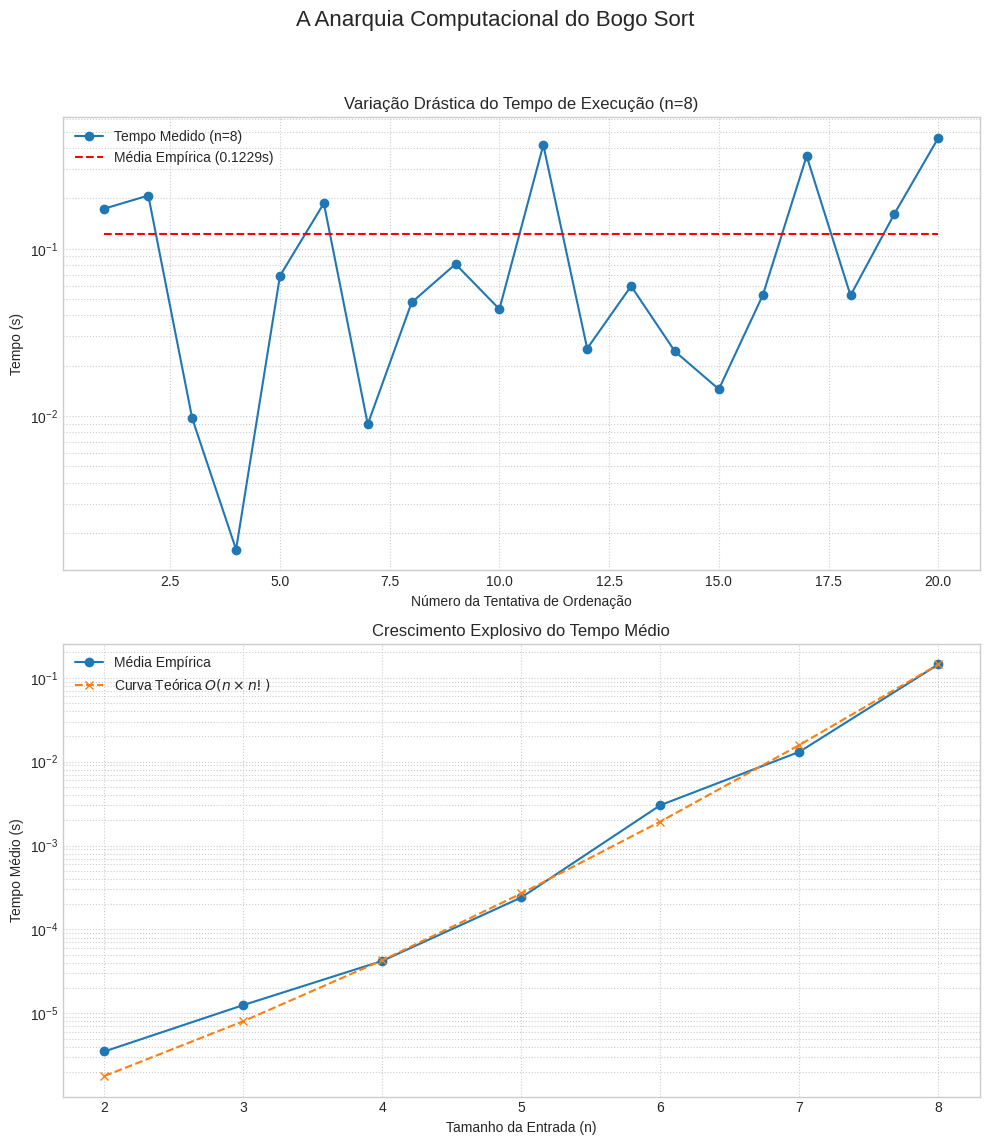

In [61]:
# Importações para a demonstração do Bogo Sort
import random
import time
import math
import statistics
import matplotlib.pyplot as plt

# --- Definições do Bogo Sort ---

def is_sorted(arr):
    """Verifica se a lista está ordenada."""
    for i in range(1, len(arr)):
        if arr[i] < arr[i-1]:
            return False
    return True

def bogo_sort(arr):
    """Embaralha até que a lista fique ordenada."""
    # Criamos uma cópia para não modificar a original durante as tentativas
    a = arr.copy()
    while not is_sorted(a):
        random.shuffle(a)
    return a

def generate_random_array(n, min_val=1, max_val=100):
    """Gera uma lista de inteiros aleatórios."""
    return [random.randint(min_val, max_val) for _ in range(n)]

print("--- Iniciando a demonstração do Bogo Sort ---")
print("Isso pode levar alguns minutos, especialmente para os tamanhos maiores (n=8)...")


# --- 1. Experimento: Variação de Tempo para n Fixo ---
n_fixo = 8
num_tentativas = 20 # 20 execuções para o mesmo n
tempos_pico = []

print(f"\nColetando {num_tentativas} medições para n={n_fixo}...")
for i in range(num_tentativas):
    arr = generate_random_array(n_fixo)
    t0 = time.perf_counter()
    bogo_sort(arr)
    t1 = time.perf_counter()
    tempos_pico.append(t1 - t0)
    print(f"  Tentativa {i+1}/{num_tentativas}: {t1-t0:.4f} segundos")

media_pico = statistics.mean(tempos_pico)


# --- 2. Experimento: Tempo Médio vs. Tamanho (n) ---
tamanhos = list(range(2, 9)) # De n=2 até n=8
tempos_medios = []

print("\nColetando médias para vários tamanhos de n...")
for n in tamanhos:
    runs = []
    # Usamos menos repetições aqui para não demorar uma eternidade
    num_reps_por_n = 5 if n < 8 else 3 # Reduz para n=8
    for _ in range(num_reps_por_n):
        arr = generate_random_array(n)
        t0 = time.perf_counter(); bogo_sort(arr); t1 = time.perf_counter()
        runs.append(t1 - t0)

    media_n = statistics.mean(runs)
    tempos_medios.append(media_n)
    print(f"  Média para n={n}: {media_n:.4f} segundos")

# --- Curvas teóricas ---
# Complexidade teórica aproximada é n * n!
ops_teoricas_n = [n * math.factorial(n) for n in tamanhos]
# Escala para a curva teórica se ajustar visualmente aos dados medidos
fator_escala = tempos_medios[-1] / ops_teoricas_n[-1]
curva_teorica = [op * fator_escala for op in ops_teoricas_n]


# --- 3. Plotagem Final ---

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle("A Anarquia Computacional do Bogo Sort", fontsize=16)

# Gráfico 1: Variação dos picos de tempo
ax0.plot(range(1, num_tentativas + 1), tempos_pico, marker='o', linestyle='-', label=f'Tempo Medido (n={n_fixo})')
ax0.hlines(y=media_pico, xmin=1, xmax=num_tentativas, colors='red', linestyles='--', label=f'Média Empírica ({media_pico:.4f}s)')
ax0.set_title(f'Variação Drástica do Tempo de Execução (n={n_fixo})')
ax0.set_xlabel('Número da Tentativa de Ordenação')
ax0.set_ylabel('Tempo (s)')
ax0.set_yscale('log')
ax0.grid(True, which='both', linestyle=':')
ax0.legend()

# Gráfico 2: Crescimento do tempo médio
ax1.plot(tamanhos, tempos_medios, marker='o', linestyle='-', color='C0', label='Média Empírica')
ax1.plot(tamanhos, curva_teorica, marker='x', linestyle='--', color='C1', label=r'Curva Teórica $O(n \times n!)$')
ax1.set_title('Crescimento Explosivo do Tempo Médio')
ax1.set_xlabel('Tamanho da Entrada (n)')
ax1.set_ylabel('Tempo Médio (s)')
ax1.set_yscale('log')
ax1.set_xticks(tamanhos)
ax1.grid(True, which='both', linestyle=':')
ax1.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Análise dos Resultados

Os gráficos acima nos contam duas histórias aterrorizantes sobre o Bogo Sort:

1.  **Gráfico de Variação (Superior):** Mesmo para um `n` fixo, o tempo de execução é completamente imprevisível. Algumas tentativas encontram a solução "rapidamente" por pura sorte, enquanto outras demoram ordens de magnitude a mais. A escala logarítmica no eixo Y é necessária para conseguir visualizar picos tão diferentes no mesmo gráfico. Isso demonstra a **total falta de confiabilidade** do algoritmo.

2.  **Gráfico de Crescimento (Inferior):** Este é ainda mais dramático. Note como a linha (em escala logarítmica) sobe quase verticalmente. Passar de `n=7` para `n=8` causa um salto massivo no tempo de execução. A curva empírica (pontos azuis) segue de perto a curva teórica de complexidade fatorial (linha tracejada laranja), provando que o modelo matemático `O(n * n!)` descreve bem o seu comportamento médio desastroso.

**Conclusão Final:**
O Bogo Sort é o "anti-algoritmo". Ele existe para nos ensinar, por contraste, o valor do design inteligente, da estrutura e da matemática por trás de algoritmos eficientes. Ele nos faz apreciar a beleza de uma solução `O(n log n)` e até mesmo a respeitabilidade de uma solução `O(n²)`.

Nunca use isso em produção. A não ser que você queira aquecer o seu processador no inverno.